In [1]:
%matplotlib inline
%env OMP_NUM_THREADS=10
%pylab inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 12]

import sys
sys.path.append("../")

import cv2
from matplotlib.colors import LinearSegmentedColormap

from typing import List
import random

from ellipse_fit.ellipse_estimater import *
from ellipse_fit.ellipse_optimizer import *
from ellipse_fit.utils import *

import g2o

env: OMP_NUM_THREADS=10
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# generate random data

In [2]:
num_points: int = 100

center: np.ndarray = np.array([4, 8])
A: float = 12
B: float = 2
points: List[np.array] = []

phi = 30

R = get_rot_mat_from_angle(phi/180*np.pi)

debug = []

for _ in range(num_points):
    a = random.gauss(A, 0.1)
    b = random.gauss(B, 0.1)
    angle = random.uniform(0.0, 2.0 * np.pi)
    points.append(center + R @ np.array([a * np.cos(angle), b * np.sin(angle)]))
    
    debug.append(angle)

# set optimizer

In [3]:
max_iterations: int = 200
verbose: bool = True
# TODO: Parse from command line

# Setup the optimizer
optimizer = g2o.SparseOptimizer()

solver = g2o.BlockSolverX(g2o.LinearSolverPCGX())

solver = g2o.OptimizationAlgorithmLevenberg(solver)
optimizer.set_algorithm(solver)

# Estimate ellipse roughly by svd

In [4]:
points = np.array(points)

init_angles,init_cx,init_cy,init_A,init_B,init_phi = est_ellipse_from_points(points)
print(init_cx,init_cy,init_A,init_B,init_phi / np.pi * 180)

5.186108921865545 8.386028986343145 11.504971449588993 2.0032823669104154 -150.89321854000673


# Set Factor Graph

In [5]:
ellipse: VertexEllipse = VertexEllipse()
ellipse.set_id(0)
ellipse.set_estimate([init_cx,init_cy,init_A,init_B,init_phi])  # some initial value for the circle
optimizer.add_vertex(ellipse)

True

In [6]:
# 2. add the points we measured

est_rot = get_rot_mat_from_angle(init_phi)

for i,(point, angle) in enumerate(zip(points,init_angles),1):
        
    theta: VertexTheta = VertexTheta()
    theta.set_id(i)
    theta.set_estimate([angle])
    
    #if i < 2:
    #    theta.set_fixed(True)
    
    optimizer.add_vertex(theta)

    edge: EdgePointOnEllipse = EdgePointOnEllipse()
    edge.set_information(np.identity(2))
  
    edge.set_vertex(0, ellipse)
    edge.set_vertex(1, theta)

    edge.set_measurement(point)
    # print(f"error: {edge.compute_error()}")
    # print(f"edge slots: {dir(edge)}")
    optimizer.add_edge(edge)

In [7]:
print(f"Number of vertices: {len(optimizer.vertices())}")
print(f"Number of edges: {len(optimizer.edges())}")

Number of vertices: 101
Number of edges: 100


# Execute optimization

In [8]:
# perform the optimization
optimizer.initialize_optimization()
optimizer.set_verbose(False)


for i in range(max_iterations):
    print(f"Iteration {i}:")
    
    # Optimize one iteration
    optimizer.optimize(1)
    
    # Compute and print total chi^2 error
    total_chi2 = optimizer.active_chi2()
    print(f"Total chi^2 error: {total_chi2}")

Iteration 0:
Total chi^2 error: 88.03407179434448
Iteration 1:
Total chi^2 error: 29.363192790555274
Iteration 2:
Total chi^2 error: 13.479543990854303
Iteration 3:
Total chi^2 error: 10.023668462125165
Iteration 4:
Total chi^2 error: 8.451703030239372
Iteration 5:
Total chi^2 error: 7.437611113615461
Iteration 6:
Total chi^2 error: 6.6798803655071435
Iteration 7:
Total chi^2 error: 6.080079460693561
Iteration 8:
Total chi^2 error: 5.58407216070904
Iteration 9:
Total chi^2 error: 5.170945306444678
Iteration 10:
Total chi^2 error: 4.815762974540927
Iteration 11:
Total chi^2 error: 4.506347630733191
Iteration 12:
Total chi^2 error: 4.235267287634628
Iteration 13:
Total chi^2 error: 3.9923221584670427
Iteration 14:
Total chi^2 error: 3.776531036128131
Iteration 15:
Total chi^2 error: 3.580019038228035
Iteration 16:
Total chi^2 error: 3.402744772984341
Iteration 17:
Total chi^2 error: 3.240884302050591
Iteration 18:
Total chi^2 error: 3.0919445593886263
Iteration 19:
Total chi^2 error: 2.9

In [9]:
cx_est,cy_est,a_est,b_est,phi_est = optimizer.vertices()[0].estimate()

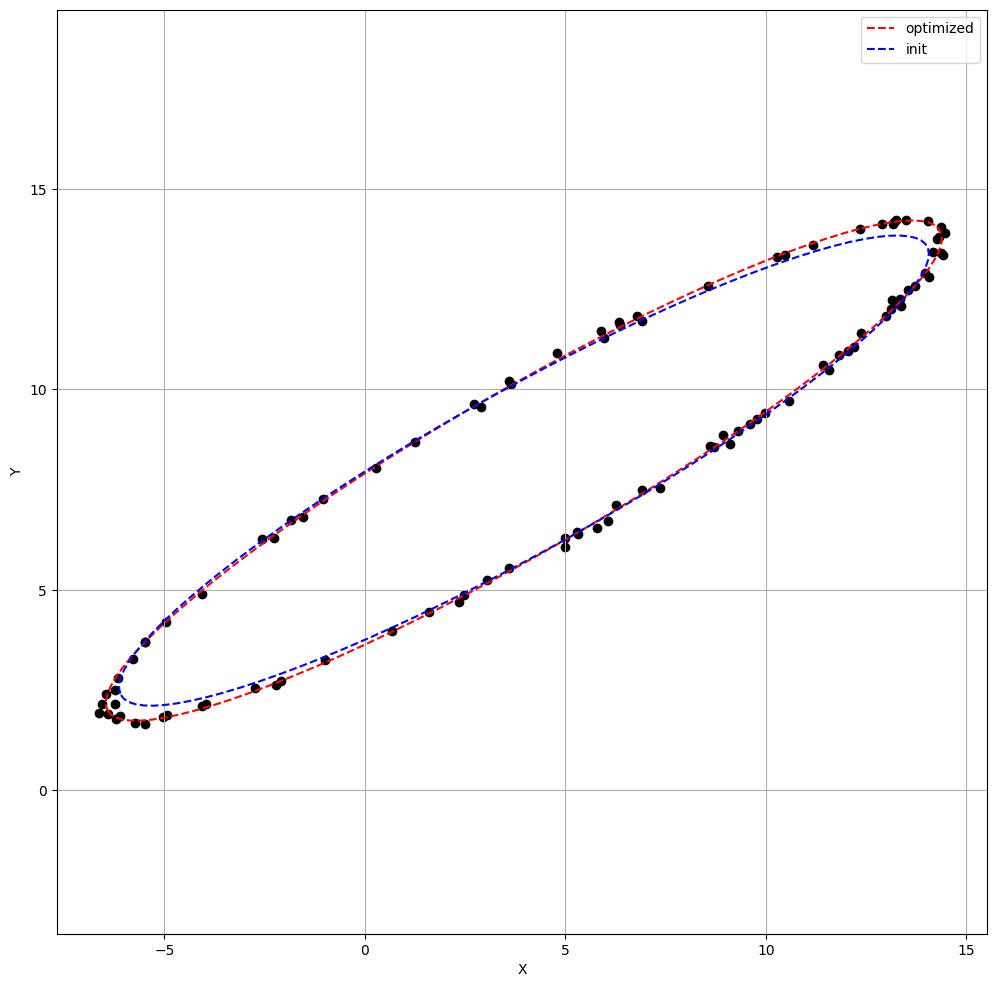

In [10]:
fix,ax =plt.subplots()

ax.axis('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid(True)

def draw_eclipse(a,b,phi,c='k',label=None):

    # Generate parametric points along the ellipse
    t = np.linspace(0, 2*np.pi, 100)
    x = a * np.cos(t)
    y = b * np.sin(t)

    # Create rotation matrix
    R = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]])

    # Apply rotation transformation
    points_optim = np.dot(R, np.vstack((x, y))) + np.array([[cx_est], [cy_est]])

    # Plot the rotated ellipse
    ax.plot(points_optim[0], points_optim[1],c=c,label=label,linestyle = "dashed")

draw_eclipse(a_est,b_est,phi_est,'r','optimized')

draw_eclipse(init_A,init_B,init_phi,'b','init')

dd = np.array(points).T
ax.scatter(dd[0,:],dd[1,:],c='k')
ax.legend()
plt.show()
